# Segmentation Parameter Selection

Many of the segmentation algorithms work by identifying a threshold level above which the start or end of a segment is triggered. Identifying the correct threshold for a dataset can be challenging. The Toolkit has some built in heuristics for identifying the best parameters for some of the segmentation algorithms. In some cases though, you may want to select the parameters manually. This tutorial will show you how to use the Python SDK to select good parameters

## Try It Yourself

You can [download the Notebook file here](https://sensiml.com/documentation/_static/file/selecting-parameters-for-segmentation-algorithms.zip) to follow along with this tutorial in your own environment.

## Prerequisites

* Download the [Demo Project](https://sensiml.com/documentation/_static/file/segment-demo-project.zip) and extract into this folder
* Update to the latest SensiML Python SDK
* To see the visualizations install ipywidgets

In [ ]:
!pip install ipywidgets sensiml -U


## Overview

In this tutorial we will

* Load a .DCLPROJ file into the Python SDK using the DCLProject API
* Upload a .DCLPROJ file as a new project to the server using the Client
* Visualize the threshold space for segmentation algorithms and select an appropriate threshold
* Run the Segmentation algorithm and compare the generated segments to the ground truth
* Compare the generated segments to the manually labeled segments

In [2]:
from sensiml import Client
from sensiml.dclproj import DCLProject, plot_threshold_space, DataSegments, segment_list_to_datasegments

## 1 Load a .DCLPROJ file into the Python SDK using the DCLProject API

The DCLProject API provides read-only access to a .DCLPROJ file which is the native database of a Data Studio project. To load the project 

In [3]:
DCLP_PROJECT_PATH = "DemoProject/DemoProject.dclproj"

dcl = DCLProject(path=DCLP_PROJECT_PATH)

## 2 Upload a .DCLPROJ file using the Python SDK Client

You can use the client to upload either a .DCLPROJ or .DCLI file. The .DCLPROJ format is a database format used by the Data Studio. The .DCLI file is a JSON format is open sourced which also fully describes the project. You can read more about the .DCLI format in our documentation. For this example we will use the .DCLPROJ format.

In [4]:
client = Client()

client.upload_project("Segment Demo Project", DCLP_PROJECT_PATH)
client.project = "Segment Demo Project"

Project with this name already exists.


select and set the variables for the GROUND_TRUTH_SESSION, PREDICTED_SESSION, and FILENAME from the .dcproj database

In [5]:
client.list_captures()

,Name,Last Modified,Created,UUID
0,File1.csv,2023-02-24T20:13:25.553485Z,2023-02-24T20:13:25.553485Z,a877cc1f-ce30-44c8-b345-f35daa83939c


In [ ]:
client.list_segmenters()[["name","custom","created_at"]]

In [7]:
GROUND_TRUTH_SESSION = "Training Session"
FILENAME="File1.csv"

## 3 Visualize the threshold space for segmentation algorithms and select an appropriate threshold

**threshold_width** is the region the threshold space is calculated over.

**threshold type** is the type of calculation performed on sensor data within that region. The values of the threshold type are (absolute sum, sum, variance, std)

**column_of_interest** is the column of sensor data used to compare against the threshold

The larger the threshold width the less sensitive to noise the threshold will be, but the slower it will be to trigger. Select different parameters below to see how it affects the threshold space.


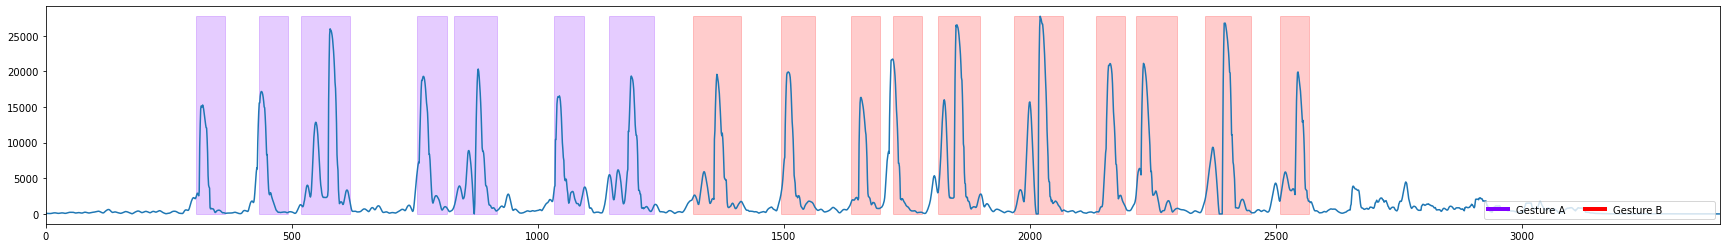

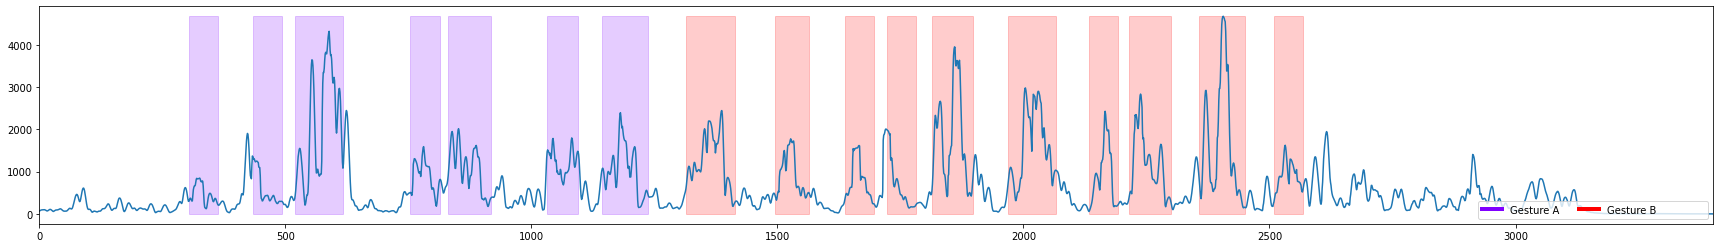

In [8]:
threshold_width=15 # threshold
threshold_type='std' #"absolute sum", "std", "variance"

capture = dcl.get_capture(FILENAME)
gt_segs = dcl.get_capture_segments(FILENAME, GROUND_TRUTH_SESSION)

sensor_columns_to_use = ['AccelerometerZ', 'GyroscopeX'] #'AccelerometerX', 'AccelerometerY', 'GyroscopeY', 'GyroscopeZ'

for column_of_interest in sensor_columns_to_use:
    plot_threshold_space(capture, column_of_interest, gt_segs, threshold_type=threshold_type, threshold_width=threshold_width)

## 4 Run the Segmentation algorithm and compare the generated segments to the ground truth

In the following cell the **Windowing Threshold Segmentation** algorithm is used as the segmentation algorithm with the input parameters:

* **column_of_interest**: AccelerometerZ 
* **threshold_space_width** 15 
* **threshold_space** std

The function will execute a pipeline job in the cloud and return the results which are converted into a DataSegments Obj

In [9]:
client.pipeline="Segmenter Pipeline"

client.pipeline.reset()
client.pipeline.set_input_capture([FILENAME])

# Set the Windowing Threshold to the values you would like to have in the segmenter algorithm
client.pipeline.add_transform("Windowing Threshold Segmentation", params={"column_of_interest": 'AccelerometerZ',
                                "window_size": 100,
                                "offset": 50,
                                "vt_threshold": 10000,
                                "threshold_space_width": 15,
                                "comparison": "maximum", #options: <maximum/minimum>,
                                "threshold_space": "std", #options: <std/absolute sum/sum/variance/absolute avg>,
                                "return_segment_index": True,
                                })

r,s = client.pipeline.execute()
new_segs  = segment_list_to_datasegments(r).nearest_labels(gt_segs, verbose=False)

Capture files do not have group columns, use a data file if you need group columns.
Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: File1.csv                 		Type: capturefile              
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Windowing Threshold Segmentation 		Type: segmenter                
------------------------------------------------------------------------
------------------------------------------------------------------------



Results Retrieved... Execution Time: 0 min. 0 sec.


## 5 Compare the generated segments to the manually labled ground truth

The DataSegments obj has a number of APIs which are very useful for manipulating, visualizing, and comparing segments. To see a comparison between the ground truth segments and the predicted segments use the confusion_matrix API

In [10]:
new_segs.confusion_matrix(gt_segs)

Pred Session: 
Model: 
-----------  ---------  ---------  ---  -------  -------
             Gesture A  Gesture B  UNK  Support  Sense %
Gesture A            7          0    0        7    100.0
Gesture B            0          9    1       10     90.0
UNK                  0          0    0        0        0
-----------  ---------  ---------  ---  -------  -------
Total                7          9    1       17
Pos_Pred(%)      100.0      100.0    0   Acc(%)    94.12
-----------  ---------  ---------  ---  -------  -------


You can also use the DataSegments plot_segments API to plot only the labels directly from a DataSegments object.

Predicted
Ground Truth


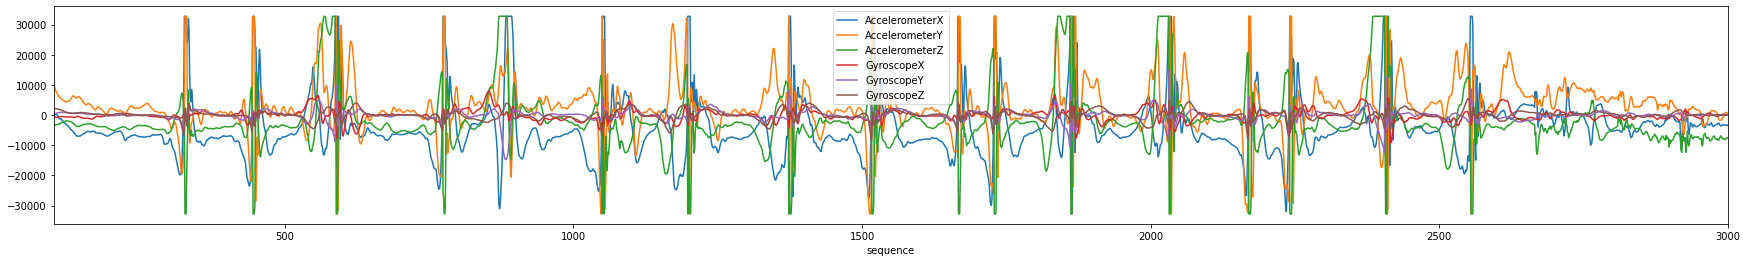

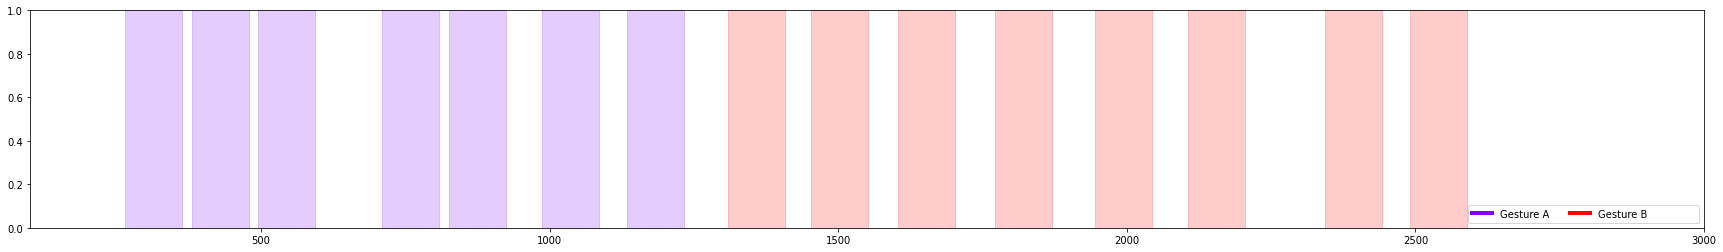

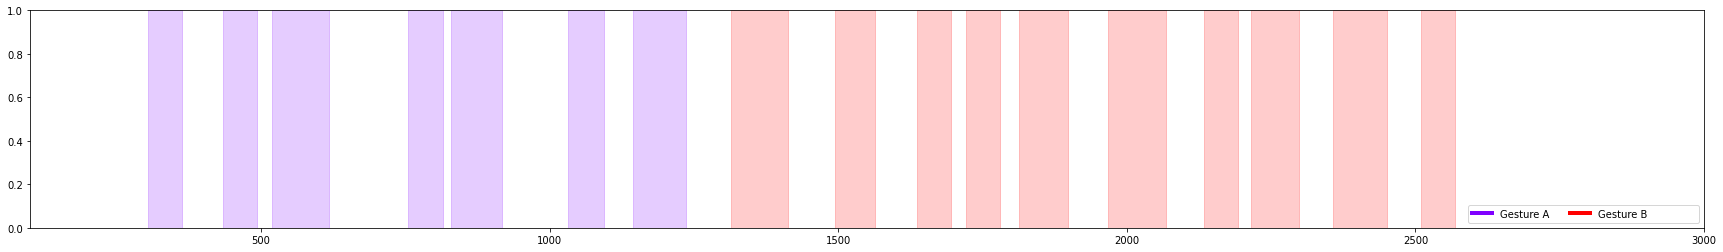

In [28]:
xlim=(100,3000)
ax = capture.plot(figsize=(16,4), xlim=xlim)
print("Predicted")
new_segs.plot_segments(figsize=(16,4), xlim=xlim)
print("Ground Truth")
gt_segs.plot_segments(figsize=(16,4), labels=new_segs.label_values, xlim=xlim)

This tutorial has demonstrated how to select parameters for the Segmentation algorithms by created a plot that transforms the sensor data into the threshold space. You can use this to select the parameters for your own segmentation algorithms.